In [24]:
from nilearn.image import threshold_img
from nilearn.input_data import NiftiMasker
import nilearn.image as image
from nilearn.plotting import plot_roi
from sklearn.svm import LinearSVR
from sklearn.preprocessing import minmax_scale
from sklearn.metrics import r2_score
from scipy.stats import zscore
import pickle



%pylab inline


def make_peer_rois(peer1,peer2,count=1000,useStandardMask=False):
    #first loop over L and R eyes
    ROI_maps=[]
    
    #first load peer1 and peer2 instead of calling filenames
    peer1_img=image.load_img(peer1)
    peer2_img=image.load_img(peer2)
    
    for eye in ['L','R']:
        eye_mask='/home/jmuraskin/standard/MNI152_T1_3mm_eye_mask_%s.nii.gz' % eye
        # fit and transform the masks

        peer1_Masker = NiftiMasker(eye_mask, detrend=True)

        ts_peer1 = peer1_Masker.fit_transform(peer1_img)
        peer2_Masker = NiftiMasker(eye_mask, detrend=True)
        ts_peer2 = peer2_Masker.fit_transform(peer2_img)
        #calculate the standard deviations and argsort for indx
        peer1_stds=np.std(ts_peer1,axis=0)
        
        peer2_stds=np.std(ts_peer2,axis=0)
       
        if useStandardMask:
            peer1_indx=np.nonzero(peer1_stds)
            peer2_indx=np.nonzero(peer2_stds)
            top_indx=np.intersect1d(peer1_indx,peer2_indx)
        else:
            peer1_indx=np.argsort(peer1_stds)
            peer2_indx=np.argsort(peer2_stds)
            #find where for both peer scans the voxel was in the top ncounts
            top_indx=np.intersect1d(peer1_indx[-count:],peer2_indx[-count:])
        #create ROI
        ROI=np.zeros((ts_peer1.shape[1]))
        ROI[top_indx]=1
        ROI_maps.append(peer1_Masker.inverse_transform(ROI))
#     else:
#         ROI_maps.append('/home/jmuraskin/standard/MNI152_T1_3mm_eye_mask_L.nii.gz')
#         ROI_maps.append('/home/jmuraskin/standard/MNI152_T1_3mm_eye_mask_R.nii.gz')
    #combine rois from L and R eyes
    peer_roi=image.math_img("img1+img2",img1=ROI_maps[0],img2=ROI_maps[1])
    
    #fit roi to time series
    masker=NiftiMasker(peer_roi,detrend=True)
    ts_peer1=masker.fit_transform(peer1_img)
    ts_peer2=masker.fit_transform(peer2_img)
    
    return peer_roi,ts_peer1,ts_peer2
 
    
def getHorizontalTS(tr=0):
    hor=np.loadtxt('../PEER/lbls_peer_hor.1D',dtype=float)
    #how many to remove
#     tr=4
    #make timeseries
    ts=[]
    if tr>0:
        hor=hor[tr/2:]

    for h in hor:
        ts.append(h)
        ts.append(h)
    return ts

def getVerticalTS(tr=0):
    hor=np.loadtxt('../PEER/lbls_peer_ver.1D',dtype=float)
    #how many to remove
#     tr=4
    #make timeseries
    ts=[]
    if tr>0:
        hor=hor[tr/2:]

    for h in hor:
        ts.append(h)
        ts.append(h)
    return ts

def peer_SVR_regression(peer1,peer2,ts):

    y = zscore(ts,axis=0)
    r2=[]
    coefs=[]
    intercepts=[]
    predictions=[]
    for n in range(2):
        if n == 0:
            X_train=ts_peer1
            X_test= ts_peer2
        else:
            X_train = ts_peer2
            X_test = ts_peer1

        X=zscore(X_train,axis=0)
        clf = LinearSVR(C=5,fit_intercept=False,tol=1e-8)
        clf.fit(X, y) 
        preds=clf.predict(zscore(X_test,axis=0))
        predictions.append(preds)
        r2.append(r2_score(y,preds))
        coefs.append(clf.coef_)
    coef=np.mean(coefs,axis=0)
    
    return coef,r2,predictions

Populating the interactive namespace from numpy and matplotlib


Horizantal Regresion Peer1: 0.78 Peer2:0.82
Vertical Regresion Peer1: 0.85 Peer2:0.85


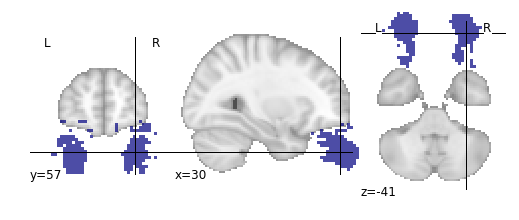

In [27]:
h_ts=getHorizontalTS()
v_ts=getVerticalTS()


subject_ID='CCD017'

peer1='/home/jmuraskin/Projects/CCD/CPAC-PEER-out/pipeline_CPAC-PEER/%s_data_/motion_correct_to_standard_other_resolutions/_scan_1/peer1_calc_tshift_resample_volreg_antswarp.nii.gz' % subject_ID
peer2='/home/jmuraskin/Projects/CCD/CPAC-PEER-out/pipeline_CPAC-PEER/%s_data_/motion_correct_to_standard_other_resolutions/_scan_2/peer2_calc_tshift_resample_volreg_antswarp.nii.gz' % subject_ID


peer_roi,ts_peer1,ts_peer2=make_peer_rois(peer1,peer2,count=1000,useStandardMask=False)

#plot the created ROI
plot_roi(peer_roi)




#Run Horizontal Regression
h_coef,h_r2,h_preds=peer_SVR_regression(ts_peer1,ts_peer2,h_ts)
print 'Horizantal Regresion Peer1: %0.2f Peer2:%0.2f' % (h_r2[0],h_r2[1])
#Run Vertical Regression
v_coef,v_r2,v_preds=peer_SVR_regression(ts_peer1,ts_peer2,v_ts)
print 'Vertical Regresion Peer1: %0.2f Peer2:%0.2f' % (v_r2[0],v_r2[1])

In [9]:
fbscan='/home/jmuraskin/Projects/CCD/CPAC-out/pipeline_CCD_v1/%s_data_/motion_correct_to_standard_other_resolutions/_scan_feedback_1/_apply_isoxfm_3.0/fb_1_calc_tshift_resample_volreg_antswarp.nii.gz' % subject_ID
masker=NiftiMasker(peer_roi,detrend=True)
fbTS=zscore(masker.fit_transform(fbscan),axis=0)



In [10]:
h_ts=minmax_scale(np.dot(fbTS,h_coef),feature_range=(min(h_ts),max(h_ts)))
v_ts=minmax_scale(np.dot(fbTS,v_coef),feature_range=(min(v_ts),max(v_ts)))

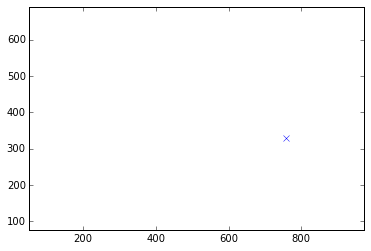

KeyboardInterrupt: 

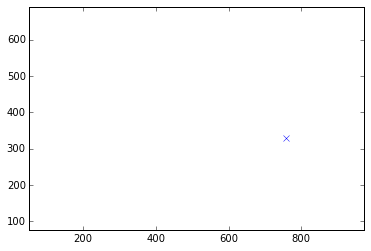

In [11]:
import time
from IPython import display
for x,y in zip(h_ts,v_ts):
    plt.cla()
    plt.plot(x,y,'bx')
    plt.xlim((min(h_ts),max(h_ts)))
    plt.ylim((min(v_ts),max(v_ts)))
    display.clear_output(wait=True)
    display.display(plt.gcf())
    time.sleep(.1)

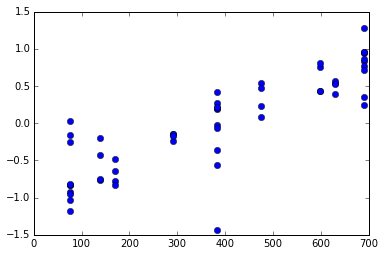

In [19]:
plt.plot(v_ts,v_preds[1],'bo')